In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import cv2

In [34]:
from visturing.properties.prop1 import load_data, load_ground_truth
from visturing.ranking import prepare_data, calculate_correlations_with_ground_truth, calculate_correlations, prepare_and_correlate, calculate_spearman

In [3]:
root_path = "../../Data/Experiment_1"
ref_path = os.path.join(root_path, "im_ref.png")

In [4]:
imgs_path = [p for p in glob(os.path.join(root_path, "*png")) if "ref" not in p]
imgs_path = list(natsorted(imgs_path))
imgs_path[:6]

['../../Data/Experiment_1/im_spectral_1.png',
 '../../Data/Experiment_1/im_spectral_2.png',
 '../../Data/Experiment_1/im_spectral_3.png',
 '../../Data/Experiment_1/im_spectral_4.png',
 '../../Data/Experiment_1/im_spectral_5.png',
 '../../Data/Experiment_1/im_spectral_6.png']

In [5]:
def load_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
    return img

In [6]:
ref_img = load_img(ref_path)
imgs = np.array([load_img(p) for p in imgs_path])
ref_img.shape, imgs.shape

((256, 256, 3), (30, 256, 256, 3))

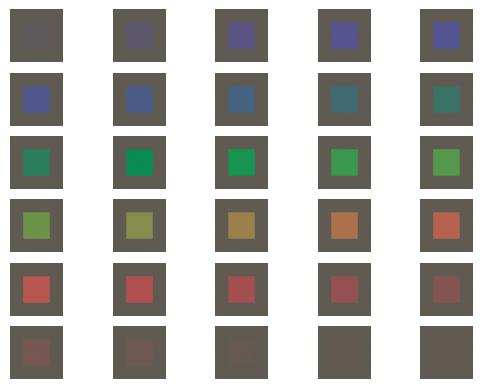

In [7]:
fig, axes = plt.subplots(6,5)
for im, ax in zip(imgs, axes.ravel()):
    ax.imshow(im)
    ax.axis("off")
plt.show()

In [8]:
import json

import jax
from jax import random, numpy as jnp
import flax
from huggingface_hub import hf_hub_download
from ml_collections import ConfigDict

from paramperceptnet.models import Baseline as PerceptNet
from paramperceptnet.configs import param_config

In [9]:
model_name = "ppnet-baseline"

In [10]:
config_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                              filename="config.json")
with open(config_path, "r") as f:
    config = ConfigDict(json.load(f))

In [11]:
from safetensors.flax import load_file

weights_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                               filename="weights.safetensors")
variables = load_file(weights_path)
variables = flax.traverse_util.unflatten_dict(variables, sep=".")
params = variables["params"]

In [12]:
model = PerceptNet(config)

In [13]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["Color"]["__call__"][0][...,0:1]
    b = extra_b["intermediates"]["Color"]["__call__"][0][...,0:1]
    return ((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [18]:
diffs_a = calculate_diffs(imgs, ref_img[None,...])
diffs_a.shape

(30,)

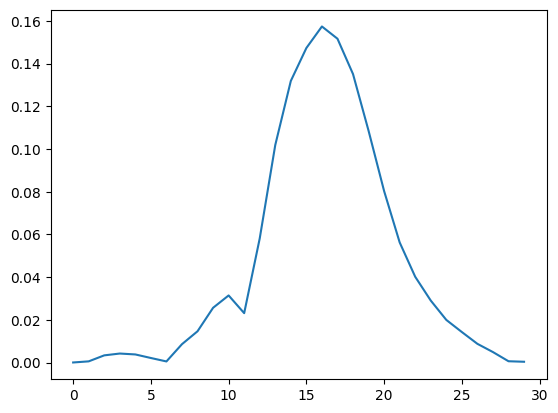

In [19]:
plt.plot(diffs_a)
plt.show()

In [20]:
_, _, x_e = load_data("../../Data/Experiment_1")

In [21]:
x_gt, y_a_gt, y_rg_gt, y_yb_gt = load_ground_truth("../../ground_truth_decalogo")

In [18]:
prepare_and_correlate(x_e, diffs, x_gt, y_a_gt)

{'spearman': np.float64(0.9483870967741934),
 'kendall': np.float64(0.8206896551724139),
 'pearson': np.float64(0.9445619259173096)}

In [22]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["Color"]["__call__"][0][...,1:2]
    b = extra_b["intermediates"]["Color"]["__call__"][0][...,1:2]
    sign = jnp.sign(a-b).mean(axis=(1,2,3))
    return sign*((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [23]:
diffs_rg = calculate_diffs(imgs, ref_img[None,...])
diffs_rg.shape

(30,)

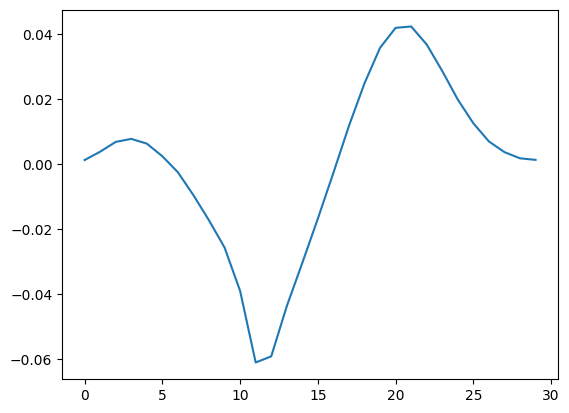

In [24]:
plt.plot(diffs_rg)
plt.show()

In [25]:
x_gt, y_a_gt, y_rg_gt, y_yb_gt = load_ground_truth("../../ground_truth_decalogo")

In [23]:
prepare_and_correlate(x_e, diffs, x_gt, y_rg_gt)

{'spearman': np.float64(0.8807563959955507),
 'kendall': np.float64(0.7195402298850575),
 'pearson': np.float64(0.9125632744795533)}

In [26]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["Color"]["__call__"][0][...,2:3]
    b = extra_b["intermediates"]["Color"]["__call__"][0][...,2:3]
    sign = jnp.sign(a-b).mean(axis=(1,2,3))
    return sign*((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [27]:
diffs_yb = calculate_diffs(imgs, ref_img[None,...])
diffs_yb.shape

(30,)

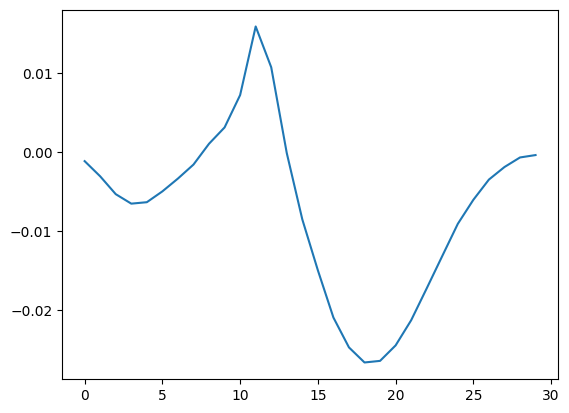

In [28]:
plt.plot(diffs_yb)
plt.show()

In [29]:
x_gt, y_a_gt, y_rg_gt, y_yb_gt = load_ground_truth("../../ground_truth_decalogo")

In [28]:
prepare_and_correlate(x_e, diffs, x_gt, y_yb_gt)

{'spearman': np.float64(-0.36952169076751945),
 'kendall': np.float64(-0.23218390804597702),
 'pearson': np.float64(-0.3238274765910126)}

In [31]:
diffs_s = np.stack([diffs_a, diffs_rg, diffs_yb])
diffs_s.shape

(3, 30)

In [32]:
gt_s = np.stack([y_a_gt, y_rg_gt, y_yb_gt])
gt_s.shape

(3, 446)

In [36]:
bs, ds = [], []
for b, d in zip(diffs_s, gt_s):
    a, b, c, d = prepare_data(x_e, b, x_gt, d)
    bs.append(b)
    ds.append(d)
b = np.array(bs)
d = np.array(ds)
b.shape, d.shape

((3, 30), (3, 30))

In [40]:
import scipy.stats as stats
stats.pearsonr(b.ravel(), d.ravel())

PearsonRResult(statistic=np.float64(0.7791958081508226), pvalue=np.float64(1.5132670600391468e-19))

In [41]:
calculate_correlations_with_ground_truth(b, d)

{'spearman': np.float64(0.7833333333333333),
 'kendall': np.float64(0.725925925925926),
 'pearson': np.float64(0.783333333333333)}